# Using Machine Learning to Identify Enron POIs 
## By Dominic Nguyen
[GitHub Repo]()

The Enron scandal, publicized in 2001, was a corporate fraud involving several Enron employees. After an extensive federal investigation, numerous persons of interests (POIs) have been identified. These POIs represent those people that have been indicted, settled, or testified in exchange for immunity. In recent years, machine learning has become a very useful tool to make predictions on existing data sets. In this project, machine learning through Python's Scikit-learn library and NumPy is used to classify POIs using a dataset of Enron employees' financial and email information. Several features are extracted from the information as inputs to a number of machine learning algorithms including Naive Bayes, decision trees, and k-means clustering. The classifiers' parameters are then tuned to provide optimal performance. Since POIs have already been identified through the federal investigation, the effectiveness of the chosen machine learning algorithm was able to be validated with test and training data and evaluated with the precision and recall metrics. 

## Data Information
The dataset contains 145 employees with 18 POIs identified from the federal investigation.

In [1]:
%matplotlib inline
import sys
import pickle
import pprint
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from sklearn.naive_bayes import GaussianNB
from feature_format import featureFormat, targetFeatureSplit
from sklearn.pipeline import Pipeline
from sklearn.cross_validation import StratifiedShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.tree import DecisionTreeClassifier
from tester import test_classifier, dump_classifier_and_data

# Load data into dictionary
with open("final_project_dataset.pkl", "r") as data_file:
    data_dict = pickle.load(data_file)

# Initial feature lists
features_list = ["poi", "bonus", "salary"]

# Format features in data
data = featureFormat(data_dict, features_list)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Initial Data Analysis
From an initial analysis of the data, an outlier and several missing data points were identified. 
### Outlier
The outlier was found when viewing a scatter plot of the Salary vs Bonus features. This outlier data point was labelled "TOTAL" and was a dictionary containing the sum values of each feature. The outlier was removed from the data set dictionary using the 'pop' method on the key value "TOTAL."

#### Figure 1

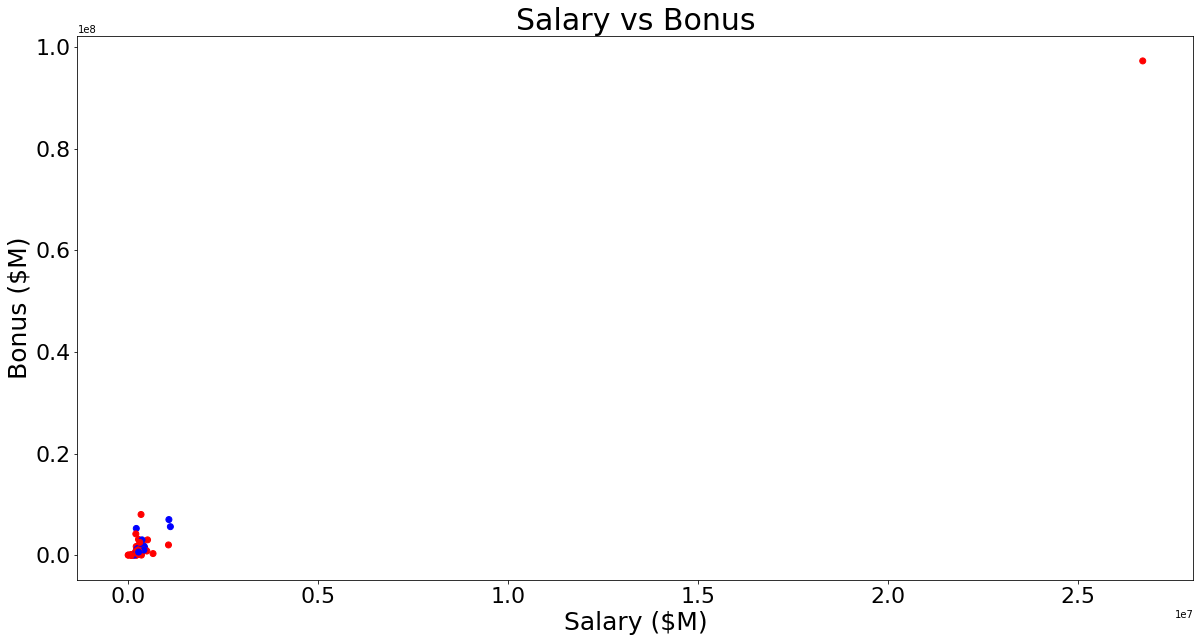

{'bonus': 97343619,
 'deferral_payments': 32083396,
 'deferred_income': -27992891,
 'director_fees': 1398517,
 'email_address': 'NaN',
 'exercised_stock_options': 311764000,
 'expenses': 5235198,
 'from_messages': 'NaN',
 'from_poi_to_this_person': 'NaN',
 'from_this_person_to_poi': 'NaN',
 'loan_advances': 83925000,
 'long_term_incentive': 48521928,
 'other': 42667589,
 'poi': False,
 'restricted_stock': 130322299,
 'restricted_stock_deferred': -7576788,
 'salary': 26704229,
 'shared_receipt_with_poi': 'NaN',
 'to_messages': 'NaN',
 'total_payments': 309886585,
 'total_stock_value': 434509511}

In [2]:
# Find outliers by plotting Salary vs Bonus with color indicating POI label
plt.subplots(figsize=(20, 10))
plt.scatter(data[:,2], data[:,1], marker='o', c = data[:,0], cmap="bwr_r")
plt.xticks(size = 22)
plt.yticks(size = 22)
plt.xlabel("Salary ($M)", size = 25)
plt.ylabel("Bonus ($M)", size = 25)
plt.title('Salary vs Bonus', size = 30)
plt.show()

# Remove TOTAL data point as it will cause outliers in features
data_dict.pop("TOTAL")

### Missing Data
Missing data values were found by iterating through each data point for each feature and checking for 'NaN' values. These' NaN' values are then replaced with a zero. A summary of the number of missing data points can be seen below.

In [3]:
# Find & print missing data points, also assign 0 to all NaN values
features_nan = {}
for name, feature in data_dict.iteritems():
    for feature_key, val in feature.iteritems():
        if val == "NaN":
            # Assign 0 to value
            feature[feature_key] = 0
            if features_nan.get(feature_key):
                features_nan[feature_key] = features_nan.get(feature_key) + 1
            else:
                features_nan[feature_key] = 1
print "-- # of Missing Values in Features --"
pprint.pprint(features_nan)
print ""

-- # of Missing Values in Features --
{'bonus': 64,
 'deferral_payments': 107,
 'deferred_income': 97,
 'director_fees': 129,
 'email_address': 34,
 'exercised_stock_options': 44,
 'expenses': 51,
 'from_messages': 59,
 'from_poi_to_this_person': 59,
 'from_this_person_to_poi': 59,
 'loan_advances': 142,
 'long_term_incentive': 80,
 'other': 53,
 'restricted_stock': 36,
 'restricted_stock_deferred': 128,
 'salary': 51,
 'shared_receipt_with_poi': 59,
 'to_messages': 59,
 'total_payments': 21,
 'total_stock_value': 20}



## Feature Creation
A new feature, `fraction_exercised_stock` was created by dividing the `exercised_stock_options` feature by the `total_stock_value` feature. It was hypothesized that the fraction of stocks that were exercised by an employee could play a role into whether that person was labelled a POI. Unfortunately, after analyzing the benefit of `fraction_exercised_stock`, it was found that the feature importance attribute from the decision classifier and the feature score reported from SelectKBest were both 0 for the created feature. Thus, `fraction_exercised_stock` provided no benefit to the classifiers used.

In [4]:
# Function to compute fraction exercised stock
def computeFraction(exercised, total):
    if exercised == 0 or total == 0:
        fraction = 0
    else:
        fraction = float(exercised) / float(total)
        
    return fraction

# Add new feature of fraction exercised stock to each data point in data set
my_dataset = data_dict
for name in my_dataset:
    
    data_point = my_dataset[name]
    total_stock_value = data_point["total_stock_value"]
    exercised_stock_options = data_point["exercised_stock_options"]
    fraction_exercised_stock = computeFraction(exercised_stock_options, total_stock_value)
    data_point["fraction_exercised_stock"] = fraction_exercised_stock

## Preparing Data

In [5]:
# Get data again after adding feature
features_list = ['poi', 'deferral_payments', 'deferred_income', 'director_fees','exercised_stock_options',
                 'expenses', 'fraction_exercised_stock', 'from_messages', 'from_poi_to_this_person',
                 'from_this_person_to_poi', 'loan_advances', 'long_term_incentive', 'other',
                 'restricted_stock', 'restricted_stock_deferred', 'salary', 'shared_receipt_with_poi',
                 'to_messages', 'total_payments', 'total_stock_value']

data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)

## Pipeline Preparation
### Feature Selection
Univariate feature selection with `SelectKBest` was employed.
### Feature Scaling
No scaling of any of the features was required as the only classifiers used, decision tree and Naïve Bayes, are not affected by scaling.
### Cross Validation Method
Validation is the strategy that is used to ensure machine learning algorithm generalizes data well.
A classic mistake in validation would be to evaluate the algorithm on the same data that was used to classify it (testing on a training data set). This would result in overfitting which is characterized by a deceptively high algorithm performance on the training data set but a low algorithm performance on the testing dataset. Overfitting occurs when the algorithm is subjected to new data it hasn't seen before for the first time during evaluation. If validation is used on a subset of the training data, validation data, then the algorithm has already been primed with new data before evaluation.

In this project, a Stratified Shuffle Split (SSS) cross validation is used to split 70% of the data into training data and 30% into testing data. SSS is inputted into GridSearch to determine the best estimator for both Naïve Bayes and decision tree algorithms. Due to the imbalance between POI and non-POIs in the data (only 18 of the 145 people are labelled as POIs) and the small data set, SSS was selected to perform multiple test/train splits to result in a more optimal model as compared to a singular test/train split.

In [6]:
# Define general parameters for basic classifiers, feature selector, and cross validation method
params = dict(feature_selection__k = ["all"])
select = SelectKBest()
sss = StratifiedShuffleSplit(labels, 10, test_size = 0.3, random_state = 12)

### Decision Tree

In [7]:
# Define classifier, pipeline, and parameters to tune for DT

clf = DecisionTreeClassifier(random_state = 42)

steps = [("feature_selection", select),
         ("classifier", clf)]

dt_pipeline = Pipeline(steps)

dt_params = dict(feature_selection__k = ["all", 1, 2, 3, 4, 5, 6, 7, 8,
                                         9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18],
                 classifier__criterion = ["gini", "entropy"],
                 classifier__min_samples_split = [2, 8, 12, 16, 20])

dt_params2 = dict(feature_selection__k = ["all", 1, 2, 3, 4, 5],
                 classifier__criterion = ["gini", "entropy"],
                 classifier__min_samples_split = [2, 8, 12, 16, 20])

### Naive Bayes

In [8]:
# Define classifier, pipeline, parameters to tune
clf = GaussianNB()

steps = [("feature_selection", select),
         ("classifier", clf)]

nb_pipeline = Pipeline(steps)

nb_params = dict(feature_selection__k = ["all", 1, 2, 3, 4, 5, 6, 7, 8,
                                         9, 10, 11, 12, 13, 14,
                                         15, 16, 17, 18])

nb_params2 = dict(feature_selection__k = ["all", 1, 2, 3, 4, 5])

## Parameter Tuning, Analyzing Feature Selection, and Evaluation

### Parameter Tuning
Tuning or hyperparameter optimization is the process of selecting the optimal values for parameters that result in the best learning algorithm performance commonly estimated through cross-validation. If these parameters are not tuned correctly, a poor performance can result. Some algorithms such as decision trees have parameters that affect how the algorithm performs classification on the training data. Changing these parameters can result in different classification of the data which results in a different algorithm performance in terms of precision and recall. The effect of tuning can be seen in **Figure 2** and **Figure 3**.

For the decision tree algorithm, `GridSearchCV` was used to determine the best values for the criterion and min_samples_split parameters. Though not a parameter of a specific algorithm, the K parameter of `SelectKBest` was also be tuned using `GridSearchCV` for both classifiers.

### Evaluation Metrics
Accuracy, precision, and recall are calculated as evaluation metrics in the provided tester.py file.
The F1 score, a weighted average of precision and recall, was also provided. These results of each algorithm can be seen in **Figure 2** and **Figure 3**.

In [9]:
# Function to optimize and evaluate classifier
def getClassifierAndData(pipeline, params, cross_val, features, labels, features_list):

    # Find parameters to optimize F1 score using Grid Search
    cv = GridSearchCV(pipeline,
                      param_grid = params,
                      scoring = "f1",
                      cv = sss)

    cv.fit(features, labels)

    clf = cv.best_estimator_
    print clf

    X_new = clf.named_steps["feature_selection"]
    
    clf_type = clf.named_steps["classifier"]
    
    # Print feature importances if classifier is a decision tree
    if isinstance(clf_type, DecisionTreeClassifier):
        print "-- Feature Importances --\n", clf_type.feature_importances_, "\n"

    # Get SKB scores rounded to 1 decimal place
    feature_scores = ['%.1f' % elem for elem in X_new.scores_]

    # Collect and print SKB features used and scores
    feature_scores_dict = {features_list[i+1] : feature_scores[i] for i in X_new.get_support(indices = True)}
    print "-- SKB Features & Scores --"
    pprint.pprint(feature_scores_dict)
    print ""

    # Evaluate classifier with provided function from Udacity
    results = test_classifier(clf, my_dataset, features_list)
    return clf, results

## Initial Evaluation of Decision Trees and Naive Bayes

In [10]:
# Get data for both DT and NB classifiers
dt_clf1a, dt_clf1a_results = getClassifierAndData(dt_pipeline, params, sss, features, labels, features_list)
dt_clf2a, dt_clf2a_results = getClassifierAndData(dt_pipeline, dt_params, sss, features, labels, features_list)
nb_clf1a, nb_clf1a_results = getClassifierAndData(nb_pipeline, params, sss, features, labels, features_list)
nb_clf2a, nb_clf2a_results = getClassifierAndData(nb_pipeline, nb_params, sss, features, labels, features_list)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x108664b18>)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
-- Feature Importances --
[ 0.          0.08779412  0.          0.25895692  0.11161502  0.
  0.10636277  0.04761905  0.05497148  0.          0.          0.
  0.11988947  0.          0.          0.14743732  0.          0.06535386
  0.        ] 

-- SKB Features & Scores --
{'deferral_payments': '0.2',
 'deferred_income': '11.6',
 'director_fees': '2.1',
 'exercised_stock_options': '25.1',
 'expenses': '6.2',
 'fraction_exercised_stock': '0.0',
 'from_messages': '0.2',
 'from_poi_to_this_person': '5.3',


#### Figure 2

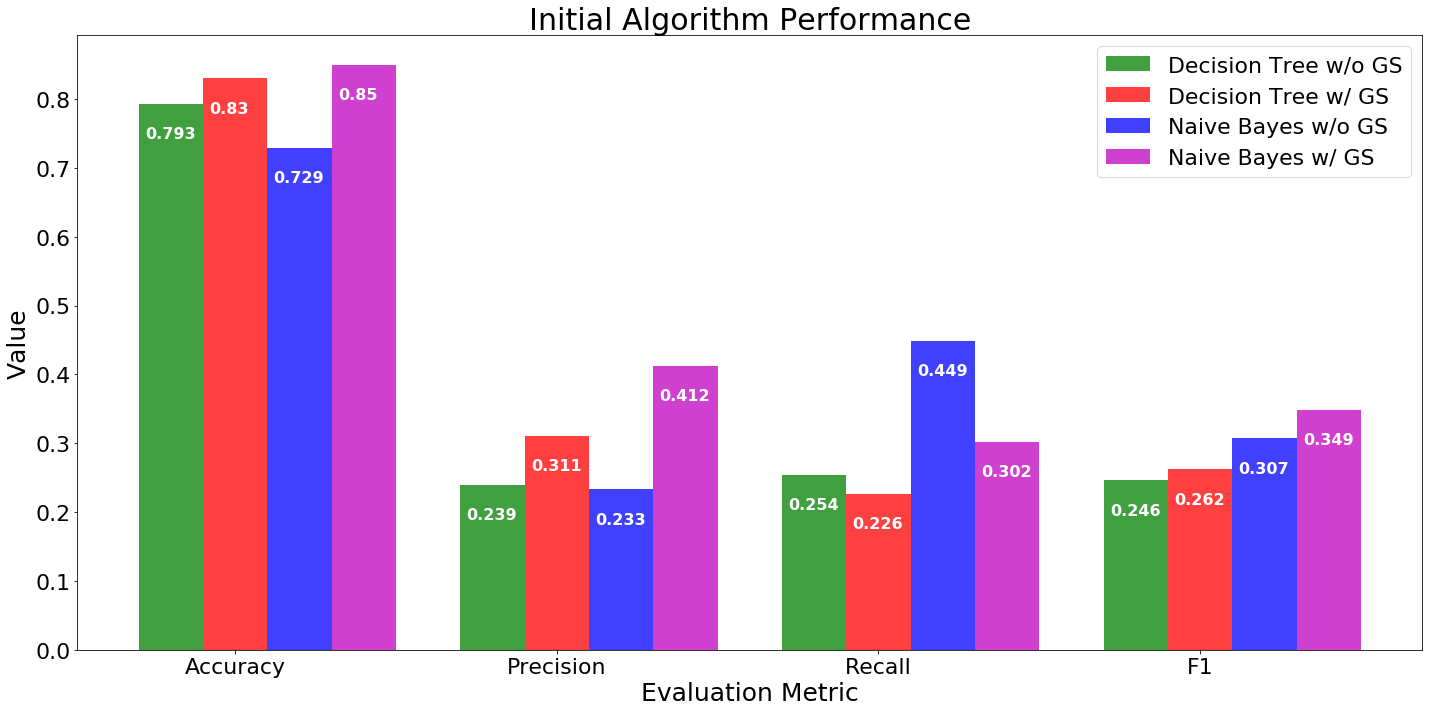

In [11]:
# Plot parameters
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(4)
bar_width = 0.2
opacity = 0.75

# Create bar charts for each algorithm
rects1 = plt.bar(index, dt_clf1a_results, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Decision Tree w/o GS')
 
rects2 = plt.bar(index + bar_width, dt_clf2a_results, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Decision Tree w/ GS')

rects3 = plt.bar(index + 2*bar_width, nb_clf1a_results, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Naive Bayes w/o GS')
 
rects4 = plt.bar(index + 3*bar_width, nb_clf2a_results, bar_width,
                 alpha=opacity,
                 color='m',
                 label='Naive Bayes w/ GS')

# Add data labels
for i, v in enumerate(dt_clf1a_results):
    ax.text(i - 0.4*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)
    
for i, v in enumerate(dt_clf2a_results):
    ax.text(i + 0.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

for i, v in enumerate(nb_clf1a_results):
    ax.text(i + 1.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

for i, v in enumerate(nb_clf2a_results):
    ax.text(i + 2.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

# Add axes titles, chart title, legend
plt.xlabel('Evaluation Metric', size = 25)
plt.ylabel('Value', size = 25)
plt.title('Initial Algorithm Performance', size = 30)
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'F1'), size = 22)
plt.yticks(size = 22)
plt.legend(fontsize = 22)
 
plt.tight_layout()
plt.show()

## Redefine Features and Data for Secondary Round of Evaluation
After using `SelectKBest` on Feature List A, a K value of 5 for the Naïve Bayes algorithm generated the highest F1 score. These 5 features, Features List B, had feature scores higher than 10 and were included in the final analysis for both classifiers. The cutoff point used to choose the top 5 features was from the K value given by SelectKBest. Features List B includes `deferred_income`, `exercised_stock_options`, `long_term_incentive`, `salary`, and  `total_stock_value`.  The feature scores from SelectKBest on Feature List B and feature importances from the decision tree classifier using GridSearch on Feature List B can be seen in the output in the 'Initial Evaluation of Decision Trees and Naive Bayes' section.

In [12]:
# Limit features with scores above 10 in new data set
features_list = ["poi", "deferred_income", "exercised_stock_options", "long_term_incentive", "salary",
                 "total_stock_value"]
data = featureFormat(my_dataset, features_list)
labels, features = targetFeatureSplit(data)
sss = StratifiedShuffleSplit(labels, 10, test_size = 0.3, random_state = 12)

## Secondary Evaluation of Decision Trees and Naive Bayes

In [13]:
# Get data for both DT and NB classifiers with new feature list
dt_clf1b, dt_clf1b_results = getClassifierAndData(dt_pipeline, params, sss, features, labels, features_list)
dt_clf2b, dt_clf2b_results = getClassifierAndData(dt_pipeline, dt_params2, sss, features, labels, features_list)
nb_clf1b, nb_clf1b_results = getClassifierAndData(nb_pipeline, params, sss, features, labels, features_list)
nb_clf2b, nb_clf2b_results = getClassifierAndData(nb_pipeline, nb_params2, sss, features, labels, features_list)

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x108664b18>)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best'))])
-- Feature Importances --
[ 0.13707148  0.29850463  0.01212571  0.38730467  0.16499352] 

-- SKB Features & Scores --
{'deferred_income': '10.9',
 'exercised_stock_options': '23.7',
 'long_term_incentive': '9.3',
 'salary': '17.1',
 'total_stock_value': '23.0'}

Pipeline(memory=None,
     steps=[('feature_selection', SelectKBest(k='all', score_func=<function f_classif at 0x108664b18>)), ('classifier', DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=N

#### Figure 3

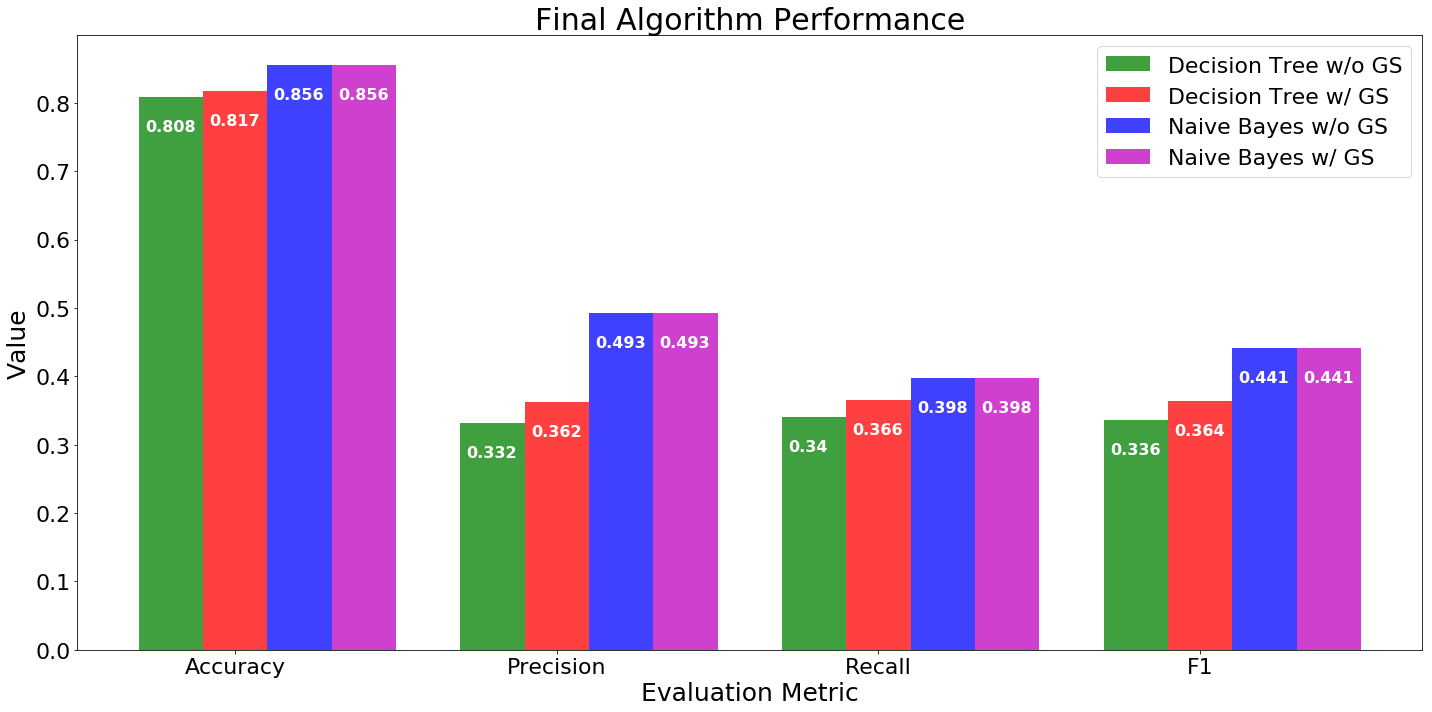

In [14]:
# Plot parameters
fig, ax = plt.subplots(figsize=(20, 10))
index = np.arange(4)
bar_width = 0.2
opacity = 0.75

# Create bar charts for each algorithm
rects1 = plt.bar(index, dt_clf1b_results, bar_width,
                 alpha=opacity,
                 color='g',
                 label='Decision Tree w/o GS')
 
rects2 = plt.bar(index + bar_width, dt_clf2b_results, bar_width,
                 alpha=opacity,
                 color='r',
                 label='Decision Tree w/ GS')

rects3 = plt.bar(index + 2*bar_width, nb_clf1b_results, bar_width,
                 alpha=opacity,
                 color='b',
                 label='Naive Bayes w/o GS')
 
rects4 = plt.bar(index + 3*bar_width, nb_clf2b_results, bar_width,
                 alpha=opacity,
                 color='m',
                 label='Naive Bayes w/ GS')

# Add data labels
for i, v in enumerate(dt_clf1b_results):
    ax.text(i - 0.4*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)
    
for i, v in enumerate(dt_clf2b_results):
    ax.text(i + 0.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

for i, v in enumerate(nb_clf1b_results):
    ax.text(i + 1.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

for i, v in enumerate(nb_clf2b_results):
    ax.text(i + 2.6*bar_width, v - 0.05, str(v), color='w', fontweight='bold', size = 16)

# Add axes titles, chart title, legend
plt.xlabel('Evaluation Metric', size = 25)
plt.ylabel('Value', size = 25)
plt.title('Final Algorithm Performance', size = 30)
plt.xticks(index + bar_width, ('Accuracy', 'Precision', 'Recall', 'F1'), size = 22)
plt.yticks(size = 22)
plt.legend(fontsize = 22)
 
plt.tight_layout()
plt.show()

The Naïve Bayes algorithm on Feature List B, nb_clf2b, resulted in the largest precision, recall, and thus F1 score. The decision tree algorithm was also tested but resulted in lower precision and recall. The performance between Naïve Bayes algorithm and decision tree algorithm on Feature List A and B can be seen in the **Figure 2** and **Figure 3** where GS = GridSearch.

From **Figure 3**, it can be seen that the Naïve Bayes algorithm, nb_clf2b, resulted in the highest accuracy, (0.856), precision (0.493), recall (0.398), and thus F1 score (0.441). Any time the final Naïve Bayes algorithm flags an employee as a POI, 49.3% of the time, the employee is actually a POI. In terms of recall, the algorithm will correctly identify 39.8% of all POIs (39.8% of POIs will be labelled as POIs). Lastly in terms of accuracy, the algorithm labelled POIs and non-POIs accurately 85.6% of the time.

## Sources

Jayant. (2016, February) Re: Final project classic mistake made on validation [Udacity]. Retrieved from https://discussions.udacity.com/t/using-sklearn-pipeline-in-final-project/199064/8

Phanny. (2017, March 23) Re: Why does sklearn.grid_search.GridSearchCV return random results on every execution? [Cross Validated] Retrieved from https://stats.stackexchange.com/questions/269300/why-does-sklearn-grid-search-gridsearchcv-return-random-results-on-every-executi

Lejlot. (2013, October 1) Re: Build Dictionary in Python Loop - List and Dictionary Comprehensions [Stack Overflow] Retrieved from https://stackoverflow.com/questions/19121722/build-dictionary-in-python-loop-list-and-dictionary-comprehensions

Paisanco. (2015, September 14) Re: Scikit: how to check if an object is a RandomizedSearchCV or a RandomForestClassifier? [Stack Overflow] Retrieved from https://stackoverflow.com/questions/32569082/scikit-how-to-check-if-an-object-is-a-randomizedsearchcv-or-a-randomforestclass